In [57]:
from os import chdir
chdir("../general")
from models import *
from util import *
from observation import *
chdir("../case-studies")

from fenics import *
from mshr import *

import numpy as np
from numpy import random
from numpy import linalg as linalg
from scipy import sparse
from scipy.sparse import linalg as splinalg

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from decimal import Decimal
from sksparse import cholmod

In [2]:
def pprint(num):
	print('%.2E' % Decimal(num))

In [3]:
random.seed(3122344)

In [4]:
# Create mesh and define function space
xL_interior = 0
xR_interior = 30
expand = 10
xL = xL_interior - expand
xR = xR_interior + expand
num_pt = 500
deltaX = (xR-xL)/num_pt

mesh = IntervalMesh(num_pt,xL,xR)
V = FunctionSpace(mesh, 'P', 1)
fem = V.element()
interior = Expression("x[0] <= 30 & x[0] >= 0 ? 1 : 0",degree=1)

In [5]:
# Define our source problem parameters
alpha = 2			  # twice the number of recursive applications
d = 1				  # dimension of the space
nu = alpha-d/2		  # matern nu parameter
rho = 2  			  # range
kappa = 8*nu/rho**2   # matern kappa parameter
sigma2 = 20            # variance of the source

In [6]:
# Define our mechanics problem parameters
diff = 0.075
diffusion = Constant(diff)
dec = 0.02
decay = Constant(dec)
advection = Expression("0.5 + 0.1*cos(6.283*(x[0]-10)/10) + 0.075*cos(9.425*(x[0]-10)/10) + 0.075*cos(15.708*(x[0]-10)/10)",degree=2,domain=mesh)
def adv(x):
	return 0.5 + 0.1*np.cos(6.283*x/10) + 0.075*cos(9.425*x/10) + 0.075*cos(15.708*x/10)
adv0 = str(adv(xL))
adv1 = str(adv(xR))
strL = "(" + str(xL) + ")"
strR = "(" + str(xR) + ")"
termL = "(" + strR + "-x[0])/(" + strR + "-" + strL + ")"
termR = "(x[0] - " + strL +")/(" + strR + "-" + strL + ")"
print("-" + adv0 + "*" + termL + " + " + adv1 + "*" + termR)
adv_BC = Expression("-" + adv0 + "*" + termL + " + " + adv1 + "*" + termR,degree=1,domain=mesh)


-0.4500000001824624*((40)-x[0])/((40)-(-10)) + 0.7499999421386044*(x[0] - (-10))/((40)-(-10))


In [7]:
# Define the source matrix
Q_source = make_matern(alpha,kappa,d,V,sigma2,threshold=1e-10)
Q_factors = make_matern_factors(alpha,kappa,d,V,sigma2)

In [8]:
# Define the source function and FEM representation of it
farm = Expression("x[0] <= 10 ? 1 : 0",degree=1)
industrial = Expression("x[0] <= 20 & x[0] > 10 ? 1 : 0",degree=1)
residential = Expression("x[0] > 20 ? 1 : 0",degree=1)

In [9]:
farm_f = Function(V)
farm_f.interpolate(farm)

ind_f = Function(V)
ind_f.interpolate(industrial)

res_f = Function(V)
res_f.interpolate(residential)

farm_vec = func_to_vec(farm_f)
ind_vec = func_to_vec(ind_f)
res_vec = func_to_vec(res_f)

In [10]:
mu_beta = 20
sigma_beta = 5
X = np.array([farm_vec,ind_vec,res_vec]).transpose()

In [11]:
#source_vec = random.multivariate_normal(np.zeros(num_pt+1),splinalg.inv(Q_source.tocsc()).todense())
beta = random.normal(loc=mu_beta,scale=sigma_beta,size=3)
source_vec = np.squeeze(mvn_invchol(Q_factors,num_pt+1)) + beta[0]*farm_vec + beta[1]*ind_vec + beta[2]*res_vec
source_f = vec_to_func(source_vec,V)
x_f = vec_to_func(beta[0]*farm_vec + beta[1]*ind_vec + beta[2]*res_vec,V)

In [12]:
# Get the mechanics problem matrices
u = TrialFunction(V)
v = TestFunction(V)
equation = diffusion*u.dx(0)*v.dx(0)*dx + advection.dx(0)*u*v*dx + advection*u.dx(0)*v*dx + decay*u*v*dx - adv_BC*u*v*ds # need the robin BC here
mass = u*v*dx
source = source_f*v*dx

In [13]:
# Assemble precision matrices
K = assemble(equation)
K = as_backend_type(K).mat()
(m,n) = K.size
K = sparse.csr_matrix(K.getValuesCSR()[::-1],shape=K.size)

L = assemble(mass)
L = as_backend_type(L).mat()
(m,n) = L.size
L = sparse.csr_matrix(L.getValuesCSR()[::-1],shape=L.size)
invL = sparse.spdiags(1/L.sum(axis=0),0,m,n)

In [14]:
I_interior_form = assemble(u*interior*dx)
I_interior_vec = as_backend_type(I_interior_form).vec().getArray()/deltaX
I_interior = sparse.diags(I_interior_vec)

In [15]:
# Solve for the steady state (w)
w = Function(V)
solve(equation==source,w)

Solving linear variational problem.


6.5856007597197355

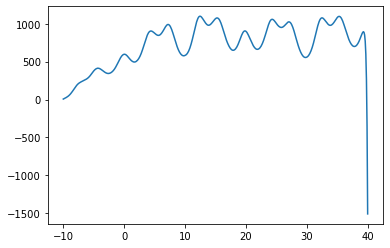

In [16]:
plot(w)
w(-10)

In [17]:
print("Amount entering:")
print(assemble(source_f*interior*dx))
print("Amount leaving/decay:")
print(dec*assemble(w*interior*dx))  # this currently ignores amount entering/leaving due to advection....

Amount entering:
644.3125884352834
Amount leaving/decay:
493.7008063213252


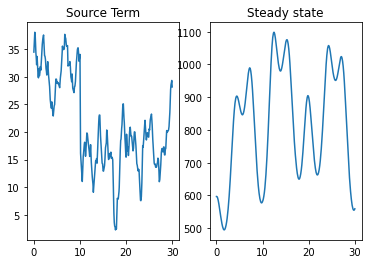

In [18]:
plt.subplot(1,2,1)
ax = plt.gca()
plotx = np.linspace(xL_interior,xR_interior,100*num_pt+1)
ax.plot(plotx,[source_f(x) for x in plotx])
ax.set_title("Source Term")
plt.subplot(1,2,2)
ax = plt.gca()
ax.plot(plotx,[w(x) for x in plotx])
ax.set_title('Steady state')
plt.show()

In [19]:
# Get observations
num_samp = 20
sigma2_eps = 0.5   
pt_inds = list(map(int,np.linspace(0,num_pt,num_samp)))
x = np.linspace(xL_interior,xR_interior,num_pt+1)
pts = x[pt_inds]
data = random.normal(scale=np.sqrt(sigma2_eps),size=num_samp) + [w(pt) for pt in pts]
O = make_obs_mat_pts([[pt] for pt in pts],fem,mesh,V,threshold=1e-10)
O = sparse.bmat([[O],[np.zeros((len(beta),num_samp))]])

In [20]:
Q_beta = sparse.diags(np.array([1/sigma_beta for i in range(3)]))
Q_prior = sparse.bmat([[K.transpose() @ invL @ Q_source @ invL @ K,-K.transpose() @ invL @ Q_source @ X],[-X.transpose() @ Q_source @ invL @ K,Q_beta + X.transpose() @ Q_source @ X]])
Q_post  = Q_prior + O @ O.transpose()/sigma2_eps

In [21]:
Q_post.shape

(504, 504)

In [22]:
mean_soln = (splinalg.spsolve(Q_post,O @ data)/sigma2_eps)[0:(num_pt+1)]
mean_source = invL @ K @ mean_soln
soln_est = vec_to_func(mean_soln,V)
source_est = vec_to_func(mean_source,V)

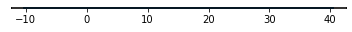

In [23]:
plot(mesh)

In [24]:
cov_post = splinalg.inv(Q_post)
cov_post_u = cov_post[0:(num_pt+1),0:(num_pt+1)]
std_post_simul = simultaneous_confint(cov_post_u.todense(),1000) 
std_post = np.sqrt(cov_post_u.diagonal())
std_soln_f = vec_to_func(std_post,V)
std_soln_f_simul = vec_to_func(std_post_simul,V)

cov_post_source = invL @ K @ cov_post_u @ K.transpose() @ invL
std_post_source_simul = simultaneous_confint(cov_post_source.todense(),1000) 
std_post_source = np.sqrt(cov_post_source.diagonal()) 
std_source_f = vec_to_func(std_post_source,V)
std_source_f_simul = vec_to_func(std_post_source_simul,V)

/Users/cokasaki/opt/anaconda3/envs/spde/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/cokasaki/opt/anaconda3/envs/spde/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/Users/cokasaki/ownCloud/Work/Research/spat_stat/final_writeup/publication_github/general/util.py:28: RuntimeWarning: covariance is not positive-semidefinite.
  sim = random.multivariate_normal(np.zeros(dim),cov,size=num_sim)


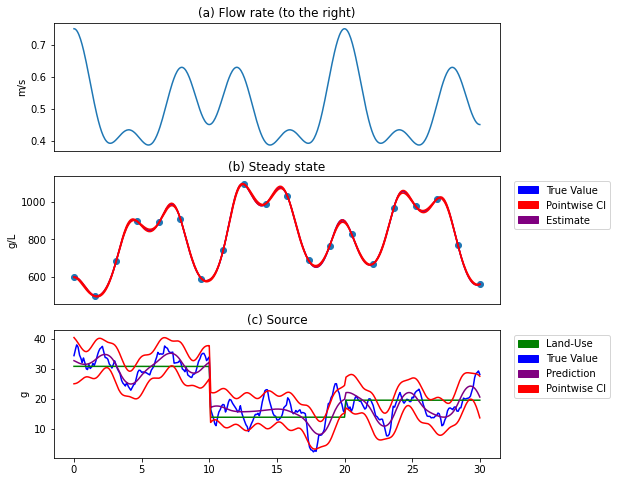

In [25]:
plt.figure(figsize=(8,8))
plt.subplot(3,1,1)
plt.plot(x,[adv(xi) for xi in x])
plt.ylabel("m/s")
plt.title('(a) Flow rate (to the right)')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
plt.subplot(3,1,2)
ax = plt.gca()
ax.plot(plotx,[w(xi) for xi in plotx],'b')
ax.set_title('(b) Steady state')
plt.ylabel("g/L")
ax.plot(plotx,[soln_est(xi) for xi in plotx],color='purple')
ax.plot(plotx,[soln_est(xi) + 1.96*std_soln_f(xi) for xi in plotx],color='r')
ax.plot(plotx,[soln_est(xi) - 1.96*std_soln_f(xi) for xi in plotx],color='r')
plt.scatter(pts,data)
plt.ylim(np.min(data)-0.25*np.std(data),np.max(data)+0.25*np.std(data))
b = mpatches.Patch(color='b', label='True Value')
r = mpatches.Patch(color='r', label='Pointwise CI')
p = mpatches.Patch(color='purple', label='Estimate')
plt.legend(handles=[b,r,p],bbox_to_anchor=(1.02,1),loc="upper left")
frame2 = plt.gca()
frame2.axes.get_xaxis().set_ticks([])
plt.subplot(3,1,3)
ax = plt.gca()
ax.plot(plotx,[source_f(xi) for xi in plotx],color='b')
ax.set_title('(c) Source')
plt.ylabel("g")
ax.plot(plotx,[x_f(xi) for xi in plotx],color='g')
ax.plot(plotx,[source_est(xi) for xi in plotx],color='purple')
#plot(source_est + std_source_f,color='r')
#plot(source_est - std_source_f,color='r')
ax.plot(plotx,[source_est(xi)+1.96*std_source_f(xi) for xi in plotx],color='r')
ax.plot(plotx,[source_est(xi)-1.96*std_source_f(xi) for xi in plotx],color='r')
plt.ylim(np.min(mean_source)-1.2*np.max(std_post_source),np.max(mean_source)+1.2*np.max(std_post_source))
handles = [mpatches.Patch(color='g', label='Land-Use'),
           mpatches.Patch(color='b', label='True Value'),
           mpatches.Patch(color='purple', label='Prediction'),
           mpatches.Patch(color='r', label='Pointwise CI')]
plt.legend(handles=handles,bbox_to_anchor=(1.02,1),loc="upper left")
frame3 = plt.gca()
plt.show()

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


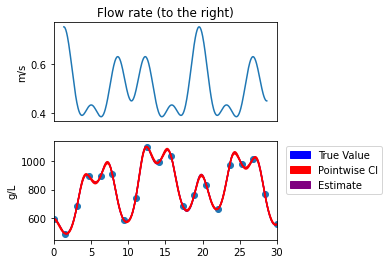

In [26]:
plt.figure(figsize=(4,4))
plt.subplot(2,1,1)
plt.plot(x,[adv(xi) for xi in x])
plt.ylabel("m/s")
plt.title('Flow rate (to the right)')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
plt.subplot(2,1,2)
ax = plt.gca()
ax.plot(plotx,[w(x) for x in plotx],color='b')
ax.set_title=('Steady state')
plt.xlim([xL_interior,xR_interior])
plt.ylabel("g/L")
plot(soln_est,color='purple')
#plot(soln_est + std_f,color='r')
#plot(soln_est - std_f,color='r')
plot(soln_est + 1.96*std_soln_f,color='r')
plot(soln_est - 1.96*std_soln_f,color='r')
plt.scatter(pts,data)
plt.ylim(np.min(data)-0.25*np.std(data),np.max(data)+0.25*np.std(data))
b = mpatches.Patch(color='b', label='True Value')
r = mpatches.Patch(color='r', label='Pointwise CI')
p = mpatches.Patch(color='purple', label='Estimate')
plt.legend(handles=[b,r,p],bbox_to_anchor=(1.02,1),loc="upper left")
frame2 = plt.gca()
plt.show()

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


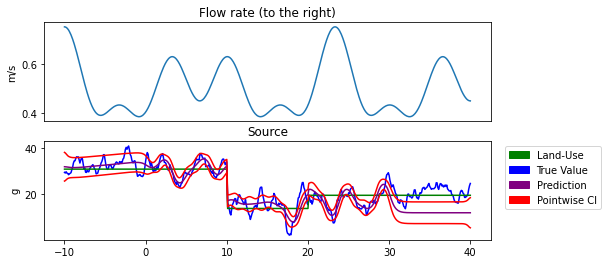

In [27]:
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.plot(x,[adv(xi) for xi in x])
plt.ylabel("m/s")
plt.title('Flow rate (to the right)')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
plt.subplot(2,1,2)
plot(source_f,color='b',title='Source')
plt.ylabel("g")
plot(x_f,color='g')
plot(source_est,color='purple')
plot(source_est + std_source_f,color='r')
plot(source_est - std_source_f,color='r')
# plot(source_est + 1.96*std_source_f_2,color='g')
# plot(source_est - 1.96*std_source_f_2,color='g')
plt.ylim(np.min(mean_source)-1.2*np.max(std_post_source),np.max(mean_source)+1.2*np.max(std_post_source))
handles = [mpatches.Patch(color='g', label='Land-Use'),
           mpatches.Patch(color='b', label='True Value'),
           mpatches.Patch(color='purple', label='Prediction'),
           mpatches.Patch(color='r', label='Pointwise CI')]
plt.legend(handles=handles,bbox_to_anchor=(1.02,1),loc="upper left")
frame3 = plt.gca()
plt.show()

Now let's take a look at the L2 norm to quantify overall accuracy on the source and solution

In [28]:
# L2-norm distances between true and estimate
print(sqrt(assemble((source_f-source_est)**2*dx)))
print(sqrt(assemble((w-soln_est)**2*dx)))
print("~")
# L2-norm distances between true and estimate, scaled by L2-norm of true
print(sqrt(assemble((source_f-source_est)**2*dx)/assemble(source_f**2*dx)))
print(sqrt(assemble((w-soln_est)**2*dx)/assemble(soln_est**2*dx)))

33.295590202434816
248.31099340962368
~
0.18938090269610336
0.046046631628190025


In [29]:
const1 = Expression("1",degree=1)
const1_f = Function(V)
const1_f.interpolate(const1)
shifted_source = source_f - assemble(source_f*interior*dx)/assemble(const1_f*interior*dx)
shifted_soln = w - assemble(w*interior*dx)/assemble(const1_f*interior*dx)

In [30]:
# L2-norm distances between true and estimate, scaled by L2-norm of true after removing mean
print(sqrt(assemble((source_f-source_est)**2*interior*dx)/assemble(shifted_source**2*interior*dx)))
print(sqrt(assemble((w-soln_est)**2*interior*dx)/assemble(shifted_soln**2*interior*dx)))

0.35114843245903576
0.01362029581637981


Now that we can calculate what effective fraction of the L2 variation from the mean is explained by our model, let's plot this as a function of # of equally spaced data points

In [31]:
def soln_and_source_error(num_samp,source=source_f,soln=w):
    pt_inds = list(map(int,np.linspace(0,num_pt,num_samp)))
    x = np.linspace(xL_interior,xR_interior,num_pt+1)
    pts = x[pt_inds]
    data = random.normal(scale=np.sqrt(sigma2_eps),size=num_samp) + [soln(pt) for pt in pts]
    O = make_obs_mat_pts([[pt] for pt in pts],fem,mesh,V,threshold=1e-10)
    O = sparse.bmat([[O],[np.zeros((len(beta),num_samp))]])
    
    Q_beta = sparse.diags(np.array([1/sigma_beta for i in range(3)]))
    Q_prior = sparse.bmat([[K.transpose() @ invL @ Q_source @ invL @ K,-K.transpose() @ invL @ Q_source @ X],[-X.transpose() @ Q_source @ invL @ K,Q_beta + X.transpose() @ Q_source @ X]])
    Q_post  = Q_prior + O @ O.transpose()/sigma2_eps
    
    mean_soln = (splinalg.spsolve(Q_post,O @ data)/sigma2_eps)[0:(num_pt+1)]
    mean_source = invL @ K @ mean_soln
    soln_est = vec_to_func(mean_soln,V)
    source_est = vec_to_func(mean_source,V)
    
    shifted_source = source - assemble(source*interior*dx)/assemble(const1_f*interior*dx)
    shifted_soln = soln - assemble(soln*interior*dx)/assemble(const1_f*interior*dx)
    
    source_error = assemble((source-source_est)**2*interior*dx)
    soln_error = assemble((soln-soln_est)**2*interior*dx)
    relative_source_error = source_error/assemble(shifted_source**2*interior*dx)
    relative_soln_error = soln_error/assemble(shifted_soln**2*interior*dx)
    return relative_source_error,relative_soln_error,source_error,soln_error

def sim_soln_and_source_error(numsamps,num_sim=1):
    
    if num_sim==1:
        mu_beta = 20
        sigma_beta = 5
        X = np.array([farm_vec,ind_vec,res_vec]).transpose()
        beta = random.normal(loc=mu_beta,scale=sigma_beta,size=3)
        source_vec = np.squeeze(mvn_invchol(Q_factors,num_pt+1)) + beta[0]*farm_vec + beta[1]*ind_vec + beta[2]*res_vec
        source = vec_to_func(source_vec,V)
        x_f = vec_to_func(beta[0]*farm_vec + beta[1]*ind_vec + beta[2]*res_vec,V)
        soln = Function(V)
        solve(equation==source*v*dx,soln)
        return np.array([soln_and_source_error(x,source,soln) for x in numsamps])
    else:
        return [sim_soln_and_source_error(numsamps) for i in range(num_sim)]
    

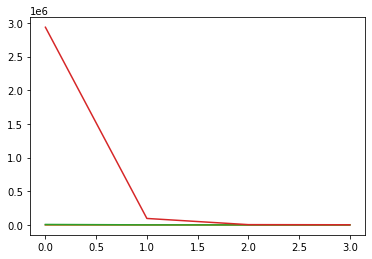

In [32]:
errors = [soln_and_source_error(x) for x in range(1,5)]
plt.plot(errors)
plt.show()

In [ ]:
nsim = 5

n = range(1,20)
logn = np.log(n)
big_logn = np.log(19) + range(1,12)
logn = list(logn) + list(big_logn)

numsamps = [int(np.ceil(np.exp(x))) for x in logn]
sim_errors = sim_soln_and_source_error(numsamps,nsim)
error_sums = 0
for i in range(nsim):
    error_sums += sim_errors[1]
error_means = error_sums / nsim

Solving linear variational problem.


In [ ]:
error_means_np = np.mean(sim_errors,axis=0)
error_means_np
error_stdev_np = np.std(sim_errors, axis=0, ddof=1)
error_stdev_np
error_stderr_np = error_stdev_np/np.sqrt(len(sim_errors))
log_error_means_np = np.mean(np.log(sim_errors),axis=0)
log_error_stdev_np = np.std(np.log(sim_errors),axis=0,ddof=1)
log_error_stderr_np = log_error_stdev_np/np.sqrt(len(sim_errors))

In [ ]:
ax = plt.gca()
ax.plot(np.sqrt(numsamps),[m[0] for m in error_means_np],label="Source")
ax.plot(np.sqrt(numsamps),[error_means_np[i][0]+1.96*error_stderr_np[i][0] for i in range(len(error_means_np))],color="r")
ax.plot(np.sqrt(numsamps),[error_means_np[i][0]-1.96*error_stderr_np[i][0] for i in range(len(error_means_np))],color="r")
ax.plot(np.sqrt(numsamps),[m[1] for m in error_means_np],label="Solution")
ax.plot(np.sqrt(numsamps),[error_means_np[i][1]+1.96*error_stderr_np[i][1] for i in range(len(error_means_np))],color="r")
ax.plot(np.sqrt(numsamps),[error_means_np[i][1]-1.96*error_stderr_np[i][1] for i in range(len(error_means_np))],color="r")

ax.legend()
ax.set_title("Error")
ax.set_ylabel("Relative Error")
ax.set_xlabel("Sqrt(N)")
plt.show()


ax = plt.gca()
ax.plot(np.sqrt(numsamps),[m[0] for m in log_error_means_np],label="Source")
ax.plot(np.sqrt(numsamps),[log_error_means_np[i][0]+1.96*log_error_stderr_np[i][0] for i in range(len(error_means_np))],color="r")
ax.plot(np.sqrt(numsamps),[log_error_means_np[i][0]-1.96*log_error_stderr_np[i][0] for i in range(len(error_means_np))],color="r")
ax.plot(np.sqrt(numsamps),[m[1] for m in log_error_means_np],label="Solution")
ax.plot(np.sqrt(numsamps),[log_error_means_np[i][1]+1.96*log_error_stderr_np[i][1] for i in range(len(error_means_np))],color="r")
ax.plot(np.sqrt(numsamps),[log_error_means_np[i][1]-1.96*log_error_stderr_np[i][1] for i in range(len(error_means_np))],color="r")
ax.legend()
ax.set_title("Log Error")
ax.set_ylabel("Log Relative Error")
ax.set_xlabel("Sqrt(N)")
plt.show()


ax = plt.gca()
ax.plot(np.log(numsamps),[m[0] for m in log_error_means_np],label="Source")
ax.plot(np.log(numsamps),[log_error_means_np[i][0]+1.96*log_error_stderr_np[i][0] for i in range(len(error_means_np))],color="r")
ax.plot(np.log(numsamps),[log_error_means_np[i][0]-1.96*log_error_stderr_np[i][0] for i in range(len(error_means_np))],color="r")
ax.plot(np.log(numsamps),[m[1] for m in log_error_means_np],label="Solution")
ax.plot(np.log(numsamps),[log_error_means_np[i][1]+1.96*log_error_stderr_np[i][1] for i in range(len(error_means_np))],color="r")
ax.plot(np.log(numsamps),[log_error_means_np[i][1]-1.96*log_error_stderr_np[i][1] for i in range(len(error_means_np))],color="r")
ax.legend()
ax.set_title("Log Error")
ax.set_ylabel("Log Relative Error")
ax.set_xlabel("Log(N)")
plt.show()

In [ ]:
soln_x = source_x = np.log(numsamps[0:5])
source_y = [m[0] for m in log_error_means_np[0:5]]
soln_y = [m[1] for m in log_error_means_np[0:5]]

In [ ]:

from scipy import stats
print(stats.linregress(soln_x,soln_y))
print(stats.linregress(source_x,source_y))

In [ ]:
soln_x = source_x = np.log(numsamps[5:10])
source_y = [m[0] for m in log_error_means_np[5:10]]
soln_y = [m[1] for m in log_error_means_np[5:10]]

In [ ]:
print(stats.linregress(soln_x,soln_y))
print(stats.linregress(source_x,source_y))

In [ ]:
num_samp=10000

mu_beta = 20
sigma_beta = 5
X = np.array([farm_vec,ind_vec,res_vec]).transpose()
beta = random.normal(loc=mu_beta,scale=sigma_beta,size=3)
source_vec = np.squeeze(mvn_invchol(Q_factors,num_pt+1)) + beta[0]*farm_vec + beta[1]*ind_vec + beta[2]*res_vec
source = vec_to_func(source_vec,V)
x_f = vec_to_func(beta[0]*farm_vec + beta[1]*ind_vec + beta[2]*res_vec,V)
soln = Function(V)
solve(equation==source*v*dx,soln)
pt_inds = list(map(int,np.linspace(0,num_pt,num_samp)))
x = np.linspace(xL_interior,xR_interior,num_pt+1)
pts = x[pt_inds]
data = random.normal(scale=np.sqrt(sigma2_eps),size=num_samp) + [soln(pt) for pt in pts]
O = make_obs_mat_pts([[pt] for pt in pts],fem,mesh,V,threshold=1e-10)
O = sparse.bmat([[O],[np.zeros((len(beta),num_samp))]])

Q_beta = sparse.diags(np.array([1/sigma_beta for i in range(3)]))
Q_prior = sparse.bmat([[K.transpose() @ invL @ Q_source @ invL @ K,-K.transpose() @ invL @ Q_source @ X],[-X.transpose() @ Q_source @ invL @ K,Q_beta + X.transpose() @ Q_source @ X]])
Q_post  = Q_prior + O @ O.transpose()/sigma2_eps

mean_soln = (splinalg.spsolve(Q_post,O @ data)/sigma2_eps)[0:(num_pt+1)]
mean_source = invL @ K @ mean_soln
soln_est = vec_to_func(mean_soln,V)
source_est = vec_to_func(mean_source,V)

cov_post = splinalg.inv(Q_post)
cov_post_u = cov_post[0:(num_pt+1),0:(num_pt+1)]
std_post_simul = simultaneous_confint(cov_post_u.todense(),1000) 
std_post = np.sqrt(cov_post_u.diagonal())
std_soln_f = vec_to_func(std_post,V)
std_soln_f_simul = vec_to_func(std_post_simul,V)

cov_post_source = invL @ K @ cov_post_u @ K.transpose() @ invL
std_post_source_simul = simultaneous_confint(cov_post_source.todense(),1000) 
std_post_source = np.sqrt(cov_post_source.diagonal()) 
std_source_f = vec_to_func(std_post_source,V)
std_source_f_simul = vec_to_func(std_post_source_simul,V)

plt.figure(figsize=(8,8))
plt.subplot(3,1,1)
plt.plot(x,[adv(xi) for xi in x])
plt.ylabel("m/s")
plt.title('(a) Flow rate (to the right)')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
plt.subplot(3,1,2)
ax = plt.gca()
ax.plot(plotx,[soln(xi) for xi in plotx],'b')
ax.set_title('(b) Steady state')
plt.ylabel("g/L")
ax.plot(plotx,[soln_est(xi) for xi in plotx],color='purple')
ax.plot(plotx,[soln_est(xi) + 1.96*std_soln_f(xi) for xi in plotx],color='r')
ax.plot(plotx,[soln_est(xi) - 1.96*std_soln_f(xi) for xi in plotx],color='r')
plt.scatter(pts,data)
plt.ylim(np.min(data)-0.25*np.std(data),np.max(data)+0.25*np.std(data))
b = mpatches.Patch(color='b', label='True Value')
r = mpatches.Patch(color='r', label='Pointwise CI')
p = mpatches.Patch(color='purple', label='Estimate')
plt.legend(handles=[b,r,p],bbox_to_anchor=(1.02,1),loc="upper left")
frame2 = plt.gca()
frame2.axes.get_xaxis().set_ticks([])
plt.subplot(3,1,3)
ax = plt.gca()
ax.plot(plotx,[source(xi) for xi in plotx],color='b')
ax.set_title('(c) Source')
plt.ylabel("g")
ax.plot(plotx,[x_f(xi) for xi in plotx],color='g')
ax.plot(plotx,[source_est(xi) for xi in plotx],color='purple')
#plot(source_est + std_source_f,color='r')
#plot(source_est - std_source_f,color='r')
ax.plot(plotx,[source_est(xi)+1.96*std_source_f(xi) for xi in plotx],color='r')
ax.plot(plotx,[source_est(xi)-1.96*std_source_f(xi) for xi in plotx],color='r')
plt.ylim(np.min(mean_source)-1.2*np.max(std_post_source),np.max(mean_source)+1.2*np.max(std_post_source))
handles = [mpatches.Patch(color='g', label='Land-Use'),
           mpatches.Patch(color='b', label='True Value'),
           mpatches.Patch(color='purple', label='Prediction'),
           mpatches.Patch(color='r', label='Pointwise CI')]
plt.legend(handles=handles,bbox_to_anchor=(1.02,1),loc="upper left")
frame3 = plt.gca()
plt.show()

In [ ]:
nomin = np.sum((invL @ K @ K.transpose() @ invL @ Q_source @ invL @ K @ K.transpose() @ invL).diagonal())

In [ ]:
denom = np.sum((invL @ K.transpose() @ K @ invL).diagonal())

In [ ]:
sigma2_eps*nomin/denom # at n = 1 we are in a bad spot already, so we cannot assume we are anywhere near convergence

In [ ]:
# let's try out the tr/tr formula for the log-log slope
# assume actual sample size of 200
nu = np.log(100)
m = np.sum(I_interior_vec)

#w,v = splinalg.eigsh(K.transpose() @ invL @ Q_source @ invL @ K,which="SM",k=500)
#wbig,vbig = splinalg.eigsh(K.transpose() @ invL @ Q_source @ invL @ K,which="LM",k=1)
#tr_S = np.sum(1/(w+np.exp(nu)/(m*sigma2_eps))) + 1/(wbig+np.exp(nu)/(m*sigma2_eps))
#tr_S2 = np.sum(1/(w+np.exp(nu)/(m*sigma2_eps))**2) + 1/(wbig+np.exp(nu)/(m*sigma2_eps))**2
#slope = -np.exp(nu)/(m*sigma2_eps)*tr_S2/tr_S

S_soln = splinalg.inv(K.transpose() @ invL @ Q_source @ invL @ K + np.exp(nu)/(m*sigma2_eps)*I_interior@I_interior.transpose())
S_denom = I_interior @ S_soln @ I_interior.transpose()
tr_denom = np.trace(S_denom.todense())

S_numer = I_interior @ S_soln @ I_interior @ I_interior @ S_soln @ I_interior.transpose()
tr_numer = np.trace(S_numer.todense())

slope = -np.exp(nu)/(m*sigma2_eps)*tr_numer/tr_denom
print(slope)

In [ ]:
# let's try out the tr/tr formula for the log-log slope
# assume actual sample size of 200
nu = np.log(100)
m = np.sum(I_interior_vec)


S_soln = splinalg.inv(K.transpose() @ invL @ Q_source @ invL @ K + np.exp(nu)/(m*sigma2_eps)*I_interior@I_interior)
S_denom = I_interior @ invL @ K @ S_soln @ K.transpose() @ invL @ I_interior
tr_denom = np.trace(S_denom.todense())

S_numer = I_interior @ invL @ K @ S_soln @ I_interior @ I_interior @ S_soln @ K.transpose() @ invL @ I_interior
tr_numer = np.trace(S_numer.todense())

slope = -np.exp(nu)/(m*sigma2_eps)*tr_numer/tr_denom
print(slope)

In [ ]:
#denom = np.sum((invL @ K @ K.transpose() @ invL @ Q_source @ invL @ K @ K.transpose() @ invL @ Q_source @ invL @ K @ K.transpose() @ invL).diagonal())
#sigma2_eps*sigma2_eps*nomin/denom

The below formula doesn't work so good because it assumes convergence 

In [ ]:
w,v = splinalg.eigsh(K.transpose() @ invL @ Q_source @ invL @ K,which="SM",k=500)
w
def error(n):
    return np.sum(1/(w+n/sigma2_eps))

plt.plot(np.linspace(0,5,num=100),np.log([error(np.exp(n)) for n in np.linspace(0,5,num=100)]))

In [ ]:
w,v = splinalg.eigsh(invL @ K @ K.transpose() @ invL @ Q_source @ invL @ K @ K.transpose() @ invL,which="SM",k=500)
w
def error_source(n):
    w,v = splinalg.eigsh(invL @ K @ (K.transpose() @ invL @ Q_source @ invL @ K + n/sigma2_eps*eye) @ K.transpose() @ invL)
    return np.sum(1/(w+n/sigma2_eps))

plt.plot(np.linspace(0,5,num=10),np.log([error(np.exp(n)) for n in np.linspace(0,1,num=10)]))

In [ ]:
stats.linregress(np.linspace(0,1,num=10),np.log([error(np.exp(n)) for n in np.linspace(0,1,num=10)]))

So the saturation model says slope of -1 (which after sqrt is -1/2) pretty much right off the bat (starts at -0.8 but still much better than we're seeing). This may be a result of our true model NOT being saturated 

But now what happens when we try observing the derived set of points:

In [ ]:
S_soln = splinalg.inv(K.transpose() @ invL @ Q_source @ invL @ K)
tr_S = np.trace(S_soln.todense())
S_soln2 = S_soln@S_soln
sherm_morr = [S_soln2[i,i]/(sigma2_eps + S_soln[i,i]) for i in range(num_pt+1)]*I_interior_vec

In [ ]:
np.array(sherm_morr)/tr_S

In [ ]:
mean_single_update = np.mean(sherm_morr[101:400])
mean_single_update/tr_S

Therefore, with the exception of the left buffer region in which mass accumulates and therefore provides lots of information, we conclude that saturation is reached after approximately 20 observations. At this point we should expect to observe an error rate of approximately:

In [ ]:
# although convergence is slow, convergence to approximation is fast

logn = list(np.log(range(1,10))) + list(np.log(10)+range(1,12))
log_error_est = []
for i in range(len(logn)):
    nu = logn[i]
    S_soln = splinalg.inv(K.transpose() @ invL @ Q_source @ invL @ K + np.exp(nu)/(m*sigma2_eps)*I_interior@I_interior)
    S_denom = I_interior @ S_soln @ I_interior
    tr_denom = np.trace(S_denom.todense())
    log_error_est += [np.log(tr_denom)+np.log((xR_interior-xL_interior)/m)]

print(logn)
print(len(logn))
print(log_error_est)
print(len(log_error_est))

# although convergence is slow, convergence to approximation is fast

log_source_error_est = []
for i in range(len(logn)):
    nu = logn[i]

    
    S_soln = splinalg.inv(K.transpose() @ invL @ Q_source @ invL @ K + np.exp(nu)/(m*sigma2_eps)*I_interior@I_interior)
    S_denom = I_interior @ invL @ K @ S_soln @ K.transpose() @ invL @ I_interior
    tr_denom = np.trace(S_denom.todense())
    log_source_error_est += [np.log(tr_denom) + np.log((xR_interior-xL_interior)/m)]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


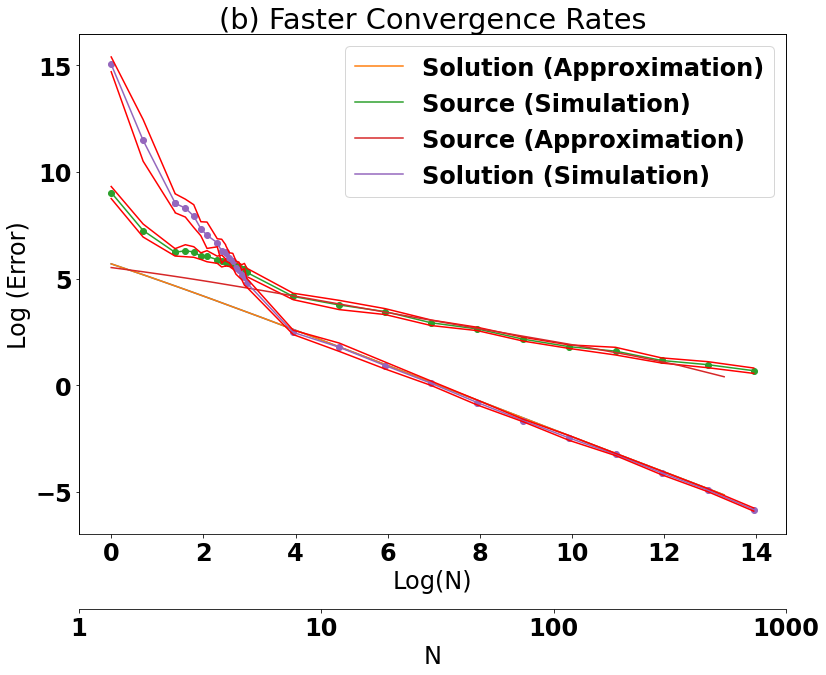

In [62]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}

matplotlib.rc('font', **font)

plt.figure(figsize=(12,10))
plt.plot(logn,log_error_est)

ax = plt.gca()
ax.plot(logn,log_error_est,label="Solution (Approximation)")
ax.plot(np.log(numsamps),[m[2] for m in log_error_means_np],label="Source (Simulation)")
ax.plot(np.log(numsamps),[m[2] for m in log_error_means_np],'C2o')
ax.plot(np.log(numsamps),[log_error_means_np[i][2]+1.96*log_error_stderr_np[i][2] for i in range(len(error_means_np))],color="r")
ax.plot(np.log(numsamps),[log_error_means_np[i][2]-1.96*log_error_stderr_np[i][2] for i in range(len(error_means_np))],color="r")
ax.plot(logn,log_source_error_est,label="Source (Approximation)")
ax.plot(np.log(numsamps),[m[3] for m in log_error_means_np],label="Solution (Simulation)")
ax.plot(np.log(numsamps),[m[3] for m in log_error_means_np],'C4o')
ax.plot(np.log(numsamps),[log_error_means_np[i][3]+1.96*log_error_stderr_np[i][3] for i in range(len(error_means_np))],color="r")
ax.plot(np.log(numsamps),[log_error_means_np[i][3]-1.96*log_error_stderr_np[i][3] for i in range(len(error_means_np))],color="r")
ax.legend()
ax.set_title("(b) Faster Convergence Rates")
ax.set_ylabel("Log (Error)")
ax.set_xlabel("Log(N)")

ax2 = ax.twiny()
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.spines["bottom"].set_position(("axes", -0.15))
ax2.set_frame_on(True)
ax2.patch.set_visible(False)

def tick_function(X):
    V = np.ceil(np.exp(X))
    return ["%.0f" % z for z in V]
ax2.spines["bottom"].set_visible(True)

new_tick_locations = np.array([np.log(0.9),np.log(9.9),np.log(99.9),np.log(999.9)])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel("N")

plt.tight_layout()
plt.savefig("../figs/accuracy2.png")